# (U) J2K Library Tutorial

(U) The J2K Library provides JPEG2000 (J2K) compression/decompression of imagery. 

- (U) The library provides for both numerically lossless (NL) and visually lossless (VL) compression
- (U) The library provides decompression of any valid JPEG2000 codestream
- (U) The library supports use of Spark to provide parallel compression of individual image tiles.
- (U) The library supports both monochromatic and multi-component images

## (U) External References

(U) This tutorial notebook uses terminology specific to the standard ISO/IEC FCD15444-1:2000 -- JPEG 2000 Part 1 Final Committee Draft Version 1.0, dated 16 March 2000 and henceforth referred to as "J2K spec". Some terms will be briefly explained for ease of readability; however, we encourage the reader to reference this standard for a more complete and wholistic description.

(U) At the core of the J2K Library is the open source library OpenJPEG.  More information on this library can be found at http://www.openjpeg.org.

## (U) Featured Examples

### [(U) Numerically Lossless (NL) Compression](#sectionNLcomp)
- (U) Single Tile
- (U) Multiple Tiles
- (U) Custom Compression Parameters

### [(U) Decompression of NL-Compressed Codestream](#sectionNLdecomp)
- (U) Resolution = 0 / Layers = 0
- (U) Resolution = 1 / Layers = 0
- (U) Resolution = 2 / Layers = 0
- (U) Resolution = 0 / Layers = 1
- (U) Resolution = 0 / Layers = 3
- (U) Resolution = 0 / Layers = 5
- (U) Resolution = 0 / Layers = 15

### [(U) Visually Lossless (VL) Compression](#sectionVLcomp)
- (U) Three components / Single Tile / NPJE Profile

### [(U) Decompression of VL-Compressed Codestream](#sectionVLdecomp)
- (U) Resolution = 0 / Layers = 3

### [(U) Compression using Spark](#sectionSpark)
- (U) Multi-Tile
- (U) Prepare for S3 multipart upload
- (U) S3 multipart upload
- (U) RDD to Codestream

## (U) Import and Setup

(U) Run these cells first.

(U) For the compression functionality, the J2K Library accepts either a Resilient Distributed Dataset (RDD) of numpy arrays or a python list of numpy arrays. For most of the examples below, our data is formatted as the latter, so these cells construct our test data accordingly. There will be one example using Spark and an imagery RDD, which will be setup below.

In [1]:
# Imports
import math
import numpy as np
from PIL        import Image, ImageDraw
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
import boto3

# Path to testing images
# This should be updated if this notebook lives elsewhere relative to the path
images_path = "../../test/test_data"

# The paths to j2k_compress and j2k_decompress should be updated if this notebook lives elsewhere relative to them
from cpaj2k.j2klib.j2k_compress   import compress
from cpaj2k.j2klib.j2k_decompress import decompress
from cpaj2k.j2klib.spark import J2kCompressRDD
from cpaj2k.j2klib.spark import j2k_rdd_codestream
from cpaj2k.j2klib.spark import prepare_j2k_for_s3
from cpaj2k.j2klib.spark import s3_upload_j2k_rdd

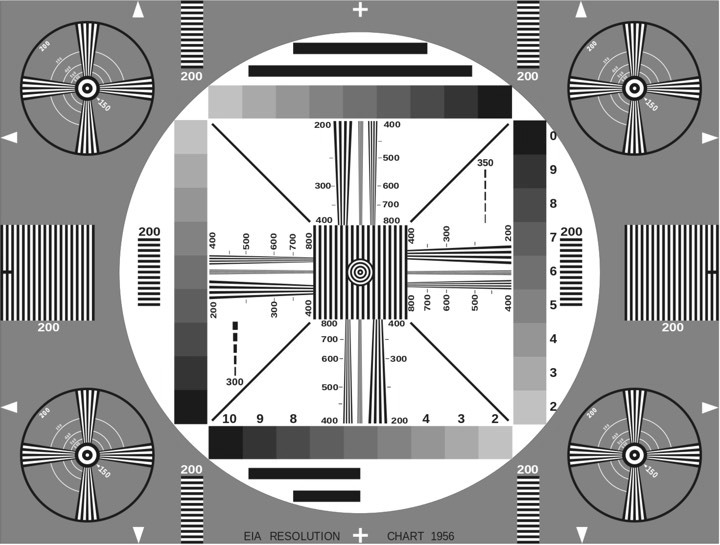

tv-test-patterns-mono.jpg Image Size (x-dimension by y-dimension): 720x545
Shape of Converted Numpy Array (rows, columns): (545, 720)



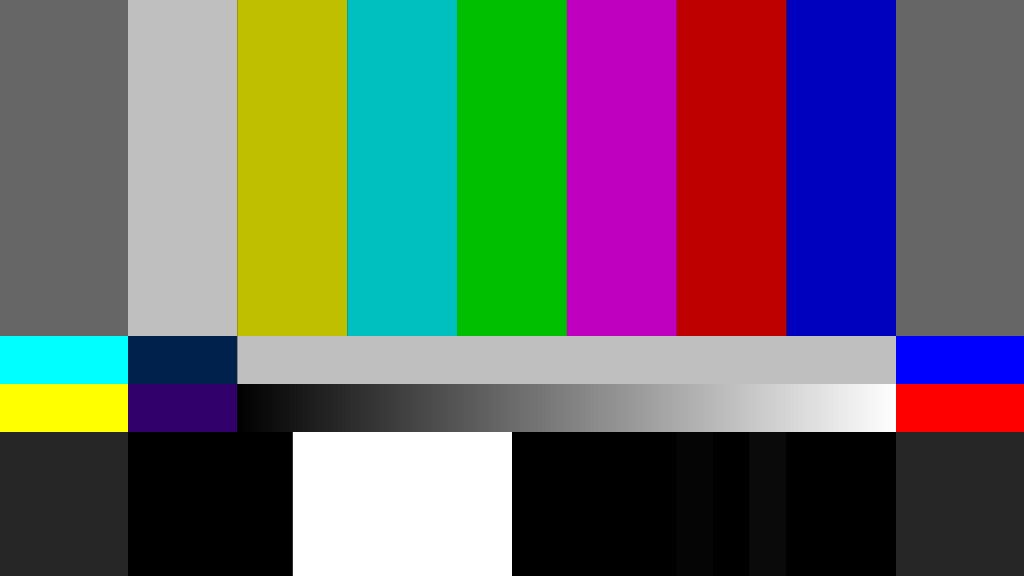

tv-test-patterns-rgb.jpg Image Size (x-dimension by y-dimension): 1024x576
Shape of Converted Numpy Array (rows, columns, components): (576, 1024, 3)


In [2]:
# Setup

# Load and display test images and image sizes
# Convert images to numpy arrays and display their shapes
mono_image      = Image.open(f"{images_path}/tv-test-pattern-mono.jpg"  )
rgb_image     = Image.open(f"{images_path}/tv-test-pattern-rgb.jpg" )

display(mono_image)
(mono_dim_x, mono_dim_y) = mono_image.size
print(f"tv-test-patterns-mono.jpg Image Size (x-dimension by y-dimension): {mono_dim_x}x{mono_dim_y}")
mono_pixels = np.array(mono_image)
print(f"Shape of Converted Numpy Array (rows, columns): {mono_pixels.shape}\n")

display(rgb_image)
(rgb_dim_x, rgb_dim_y) = rgb_image.size
print(f"tv-test-patterns-rgb.jpg Image Size (x-dimension by y-dimension): {rgb_dim_x}x{rgb_dim_y}")
rgb_pixels = np.array(rgb_image)
print(f"Shape of Converted Numpy Array (rows, columns, components): {rgb_pixels.shape}")

## (U) Convert to J2K Library Format

(U) For monochromatic images, the pixel data for each tile may be expressed as a 2D numpy array in [row,column] order.  For multi-component images, the pixel data for each tile must be expressed as a 3D numpy array in [component,row,column] order.  It is also permissible to express monochromatic images using 3D numpy arrays where the first index (*the component*) is always set to 0.

(U) Numpy converts multi-component (e.g. RGB) PIL images into arrays with shape (row, column, component).  The J2K Library, however, expects multi-component images to be specified as arrays with with shape (component, row, column).  This is not an issue for mono-chromatic images as both the numpy conversion of PIL images and the J2K Library express these with shape (row, column).

In [3]:
# Reformat the multi-component (RGB) array to the shape the J2K Library expects
rgb_pixels = np.transpose(rgb_pixels, axes=(2, 0, 1))

# Print updated shapes
print(f"mono_pixels Updated Shape: {mono_pixels.shape}")
print(f"rgb_pixels Updated Shape:  {rgb_pixels.shape}")

mono_pixels Updated Shape: (545, 720)
rgb_pixels Updated Shape:  (3, 576, 1024)


## (U) Image Tiling

(U) Images can be segmented into a grid of tiles, allowing for individual sections of the image to be separately compressed. For particularly large images, tiling has the advantage of breaking down the work needed to be done by the library into smaller quantities.  The input to the ```compress()``` function is, therefore, a list of numpy arrays where each enty in the list contains the pixel data for a single tile.

(U) The order of the tiles in the list must be in raster order. Raster order of a grid starts in the upper-left corner and continues to the right to span the first row. The order then proceeds to the leftmost grid cell of the second row and spans that row to the right. The progression proceeds in this manner all the way to the bottom-right corner of the grid.

(U) With the exception of the last row and column of tiles, all tiles must contain the same number of rows and columns of pixel data.  Every tile within a column of tiles must contain the same number of pixel columns.
Every tile with a row of tiles must contain the same number of pixel rows.  This ensures that the tiles can be formed into a single image without gaps or ragged edges.

(U) Tiles are individually compressed into J2K codestreams. The codestreams are then stitched together to form a single return codestream representing the entire image.

## <a name="sectionNLcomp"><font style=color:#4682b4;>(U) Numerically Lossless (NL) Compression </font></a>

(U) Imagery which has been NL-compressed is converted into a J2K codestream such that when said codestream is decompressed, the result is an image which is *exactly identical* to the original: every pixel-wise difference between the two images (when they are interpreted as arrays of raster data values) is exactly zero.

### (U) Single Tile

(U) In this example, the image to be compressed is monochromatic and is fully contained in a single tile.

(U) NOTE: The variables ```num_rows``` and ```num_cols``` indicate the number of rows and columns of *tiles* in the image; not the number of rows and columns of *pixels*.

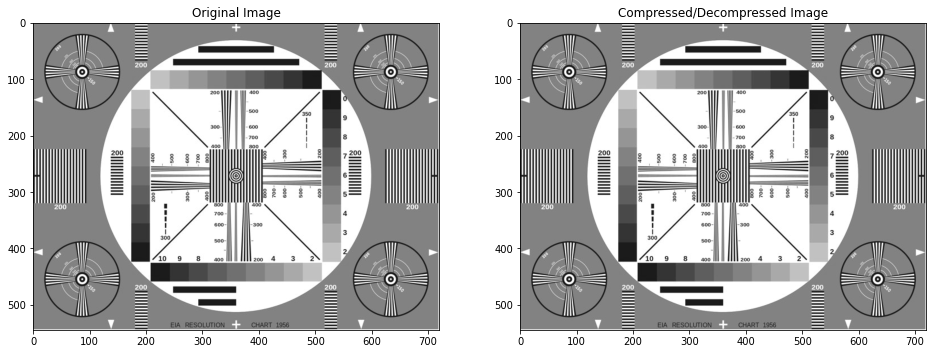

Min/Max numerical difference between the two images: (0, 0)

Images ARE numerically identical

__J2KLRA data___:
  nlevels: 5
  nlayers: 20
  bitrates: [0.03125, 0.0625, 0.125, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 2.0, 2.3, 2.8, 3.8, 8]


In [4]:
# Prepare raster data for passage into compress()
# Construct a list of a 2D numpy array, representing the sole tile with dimensions (rows, columns)
mono_pixels = mono_pixels.astype("int32")
mono_pixels_lst = [mono_pixels]

# Compress using NPJE profile
#   NPJE = "NSG Preferred JPEG Encoding"; defines values for compression parameters
mono_compressed,j2klra = compress(mono_pixels_lst, num_rows=1, bpp=8, sgnd=False, 
                         compression_type="NL", profile="NPJE")

# Decompress result of compression with default parameters
mono_decompressed = decompress(mono_compressed)

# Visually compare the decompressed image to the original
mono_final_img = Image.fromarray(mono_decompressed)
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1,2,1)
plt.imshow(mono_image,cmap='gray')
plt.title('Original Image')
fig.add_subplot(1,2,2)
plt.imshow(mono_final_img,cmap='gray')
plt.title('Compressed/Decompressed Image')
plt.show()

# Numerically compare the decompressed image to the original
diff = np.subtract(mono_pixels, mono_decompressed.astype('int32'))
diff_min = np.amin(diff)
diff_max = np.amin(diff)
print(f"Min/Max numerical difference between the two images: ({diff_min}, {diff_max})\n")

if (diff_min == 0 and diff_max == 0):
    print("Images ARE numerically identical")
else:
    print("Oops... Images are NOT numerically identical")
    
# Display the J2KLRA support data
print('\n__J2KLRA data___:')
for k,v in j2klra.items():
    print(f'  {k}: {v}')


### (U) Multiple Tiles

(U) In this example, the image to be compressed  has 3-components (red, green, blue) and has been segmented into multiple tiles.  The nominal tile size is 400x400 pixels.  Because the image size is not an exact mulitple of the tile size, the final row and column of tiles are smaller than 400x400.

In [5]:
# Create image tiles
tile_r0_c0 = rgb_pixels[:, :400, :400]
tile_r0_c1 = rgb_pixels[:, :400, 400:800]
tile_r0_c2 = rgb_pixels[:, :400, 800:]
tile_r1_c0 = rgb_pixels[:, 400:, :400]
tile_r1_c1 = rgb_pixels[:, 400:, 400:800]
tile_r1_c2 = rgb_pixels[:, 400:, 800:]

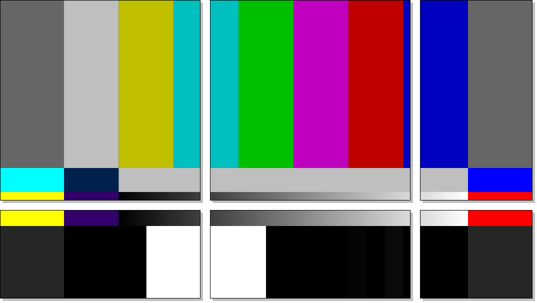

In [6]:
# Display tiles in raster order to visualize how, when combined, they span the whole image
tiles_img = Image.new('RGB', (1074,606), 'white')
tiles_drw = ImageDraw.Draw(tiles_img)

def draw_tile(tile, box):
    tile_img = Image.fromarray(np.transpose(tile, axes=(1,2,0)))
    tiles_drw.rectangle([x+5 for x in box], fill='#c0c0c0')
    tiles_img.paste(tile_img, (box[0], box[1]))
    tiles_drw.rectangle(box, outline='black')

draw_tile(tile_r0_c0, (  0,   0,  400, 400))
draw_tile(tile_r0_c1, (420,   0,  820, 400))
draw_tile(tile_r0_c2, (840,   0, 1064, 400))
draw_tile(tile_r1_c0, (  0, 420,  400, 596))
draw_tile(tile_r1_c1, (420, 420,  820, 596))
draw_tile(tile_r1_c2, (840, 420, 1064, 596))
display(tiles_img.resize((537,303)))

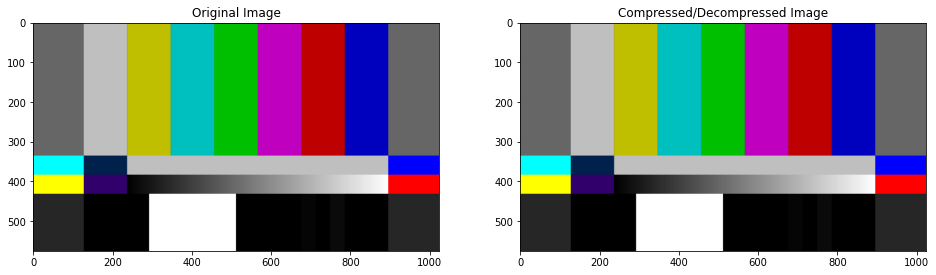

Min/Max numerical difference between the red components: (0, 0)
Min/Max numerical difference between the green components: (0, 0)
Min/Max numerical difference between the blue components: (0, 0)

Images ARE numerically identical

__J2KLRA data___:
  nlevels: 5
  nlayers: 20
  bitrates: [0.03125, 0.0625, 0.125, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 2.0, 2.3, 2.8, 3.8, 8]


In [7]:
# Prepare raster data for passage into compress()
tile_r0_c0 = tile_r0_c0.astype("int32")
tile_r0_c1 = tile_r0_c1.astype("int32")
tile_r0_c2 = tile_r0_c2.astype("int32")
tile_r1_c0 = tile_r1_c0.astype("int32")
tile_r1_c1 = tile_r1_c1.astype("int32")
tile_r1_c2 = tile_r1_c2.astype("int32")
rgb_pixels_lst = [tile_r0_c0, tile_r0_c1, tile_r0_c2, tile_r1_c0, tile_r1_c1, tile_r1_c2]

# The image is compressed using the default (NPJE) profile
rgb_compressed,j2klra   = compress(rgb_pixels_lst, num_rows=2)
rgb_decompressed = decompress(rgb_compressed)

# Visually compare the decompressed image to the original
rgb_final_img = Image.fromarray(np.transpose(rgb_decompressed, axes=(1, 2, 0)))

fig = plt.figure(figsize=(16,8))
fig.add_subplot(1,2,1)
plt.imshow(rgb_image)
plt.title('Original Image')
fig.add_subplot(1,2,2)
plt.imshow(rgb_final_img)
plt.title('Compressed/Decompressed Image')
plt.show()

# Numerically compare the decompressed image to the original
numerically_identical = True
for i,comp in enumerate(('red','green','blue')):
    diff = np.subtract(rgb_pixels[i], rgb_decompressed[i].astype('int32'))
    diff_min = np.amin(diff)
    diff_max = np.amin(diff)
    print(f"Min/Max numerical difference between the {comp} components: ({diff_min}, {diff_max})")
    
    if diff_min != 0 or diff_max != 0:
        numerically_identical = False

if numerically_identical:
    print("\nImages ARE numerically identical")
else:
    print("\nOops... Images are NOT numerically identical")
    
# Display the J2KLRA support data
print('\n__J2KLRA data___:')
for k,v in j2klra.items():
    print(f'  {k}: {v}')


### (U) Custom Compression Parameters

(U) JPEG2000 compression supports a number of configuration parameters. The J2K Library exposes a subset of these parameters which may be specified when invoking ```compress()```.

- (U) ```levels```: Number of of wavelet transforms performed 
- (U) ```layers```: Number of data layers used during the encoding of wavelet coefficients
- (U) ```alloc_type```: Strategy used for allocating encoded data to each layer
  - (U) 'bpp' = allocation is based on desired number of bits per pixel 
  - (U) 'psnr' = allocation is based on desired Peak Signal-to-Noise Ratio
- (U) ```alloc_values```: array of bpp or psnr values achieved with each subsequest layer
  - (U) For VL compression, number of values must equal number of layers
  - (U) For NL compression, no value need be specified for the final layer
- (U) ```prog_order```: Strategy used for determining order of data within each layer
  - (U) 'LRCP' = layer, resolution level, component, position
    - (U) For extraction of lower quality version of the original image at full size
  - (U) 'RLCP' = resolution level, layer, rcomponent, position
    - (U) For extraction of full quality version of the original image at reduced size

#### (U) Compression Profiles

(U) The J2K Library recognizes two predefined compression profiles:
- (U) NPJE -- NSG Preferred JPEG Encoding
- (U) EPJE -- Exploitation Preferred JPEG Encoding (*not yet implemented*)

(U) If either of these profiles is specified, any specified compression parameter is ignored.
(U) If no profile is specified, any parameter that is not explicitly specified defaults to the NPJE value.

(U) In this example, the same monochromatic image used above is compressed using a custom set of 
compression parameters.

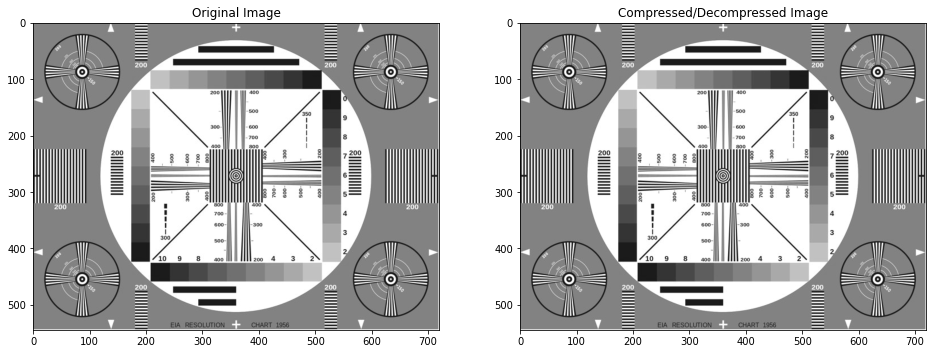

Min/Max numerical difference between the two images: (0, 0)

Images ARE numerically identical

Size of NPJE J2K codestream: 134188 bytes
Size of Custom J2K codestream: 132998 bytes


In [8]:
# NL compress with custom profile, then decompress with default parameters
# Render the result as an image
compression_parameters = {
    'levels': 8,
    'layers': 5,
    'alloc_type':'bpp',
    'alloc_values':[1/16, 1.0, 2.0, 4.0],
    'prog_order':"RLCP" }

mono_compressed_custom,_ = compress(mono_pixels_lst, num_rows=1, bpp=8, sgnd=False, 
                                compression_type="NL", **compression_parameters)

mono_decompressed_custom = decompress(mono_compressed_custom)


# Visually compare the decompressed image to the original
mono_final_img_custom = Image.fromarray(mono_decompressed_custom)
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1,2,1)
plt.imshow(mono_image,cmap='gray')
plt.title('Original Image')
fig.add_subplot(1,2,2)
plt.imshow(mono_final_img_custom,cmap='gray')
plt.title('Compressed/Decompressed Image')
plt.show()

# Numerically compare the decompressed image to the original
diff = np.subtract(mono_pixels, mono_decompressed_custom.astype('int32'))
diff_min = np.amin(diff)
diff_max = np.amin(diff)
print(f"Min/Max numerical difference between the two images: ({diff_min}, {diff_max})\n")

if (diff_min == 0 and diff_max == 0):
    print("Images ARE numerically identical")
else:
    print("Oops... Images are NOT numerically identical")
    
print()

print(f'Size of NPJE J2K codestream: {len(mono_compressed)} bytes')
print(f'Size of Custom J2K codestream: {len(mono_compressed_custom)} bytes')

## <a name="sectionNLdecomp"><font style=color:#4682b4;> (U) Decompression of NL-Compressed Codestream </font></a>

(U) JPEG2000 does not require that the full size or quality of the original image be extracted during decompression of a compressed codestream. Decompression using a subset of the resolution levels will result in an uncompressed image that is a fraction of the original size. Decompression using a subset of the (encoding) layers will result in an uncompressed image of reduced quality.

(U) The ```decompress()``` function can be invoked specifying ```resolution```, ```layers```, or both.  
- **(U) Resolution:** 
  - (U) Specifying a value of 0 (*the default*) preserves the full size of the image. 
  - (U) Specifying any other (*positive integer*) value reduces each dimension by a factor of $2^{resolution}$
- **(U) Layers:** 
  - (U) Specifying a value of 0 (*the default*) produces the highest possible quality during decompression.  
  - (U) Specifying any other (*positive integer*) value results in a loss of quality as the decompression will only use the specified number of layers of encoded data.

### (U) Reduced Resolution

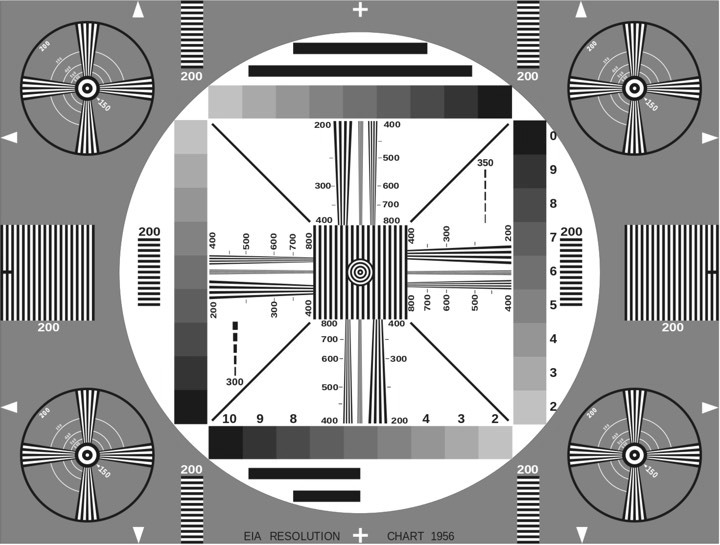

Size = 545x720


In [9]:
# (U) Full Resolution and Quality

mono_decompressed_r0_l0 = decompress(mono_compressed, resolution=0, layers=0)
img_r0_l0 = Image.fromarray(mono_decompressed_r0_l0)
display(img_r0_l0)
ncol, nrow = img_r0_l0.size
print(f'Size = {nrow}x{ncol}')

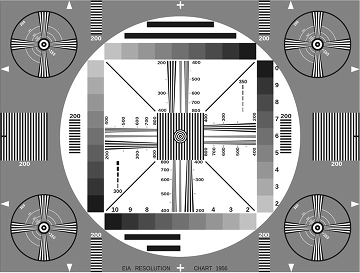

Size = 273x360


In [10]:
# Reduced Resolution by factor of 2 (Resolution = 1 / Layers = 0)

mono_decompressed_r1_l0 = decompress(mono_compressed, resolution=1)
img_r1_l0 = Image.fromarray(mono_decompressed_r1_l0)
display(img_r1_l0)
ncol, nrow = img_r1_l0.size
print(f'Size = {nrow}x{ncol}')

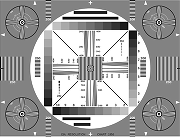

Size = 137x180


In [11]:
# Reduced Resolution by factor of 4 (Resolution = 2 / Layers = 0)

mono_decompressed_r2_l0 = decompress(mono_compressed, resolution=2)
img_r2_l0 = Image.fromarray(mono_decompressed_r2_l0)
display(img_r2_l0)
ncol, nrow = img_r2_l0.size
print(f'Size = {nrow}x{ncol}')

### (U) Reduced Quality (*fewer layers used to reconstruct image*)

The standard measure of quality for a decompressed image is PSNR (peak signal to noise ratio).
The larger the value, the better the match between the original and decompressed image.
Values in the range of 50dB or more are typically considered visually lossless.  See https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio for more information on PSNR.

In [12]:
def psnr(np_array1, np_array2, bits):
    # Compute mean squared error (MSE)
    diff           = np.subtract(np_array1, np_array2)
    squared        = np.square(diff)
    sum_of_squares = np.sum(squared)
    height, width  = np_array1.shape
    num_pixels     = height * width
    MSE            = sum_of_squares / num_pixels
    MAXI           = 2**bits - 1
    
    # Compute PSNR
    if MSE == 0:
        PSNR = math.inf
    else:
        PSNR = 20 * math.log10(MAXI) - 10 * math.log10(MSE)
    return PSNR

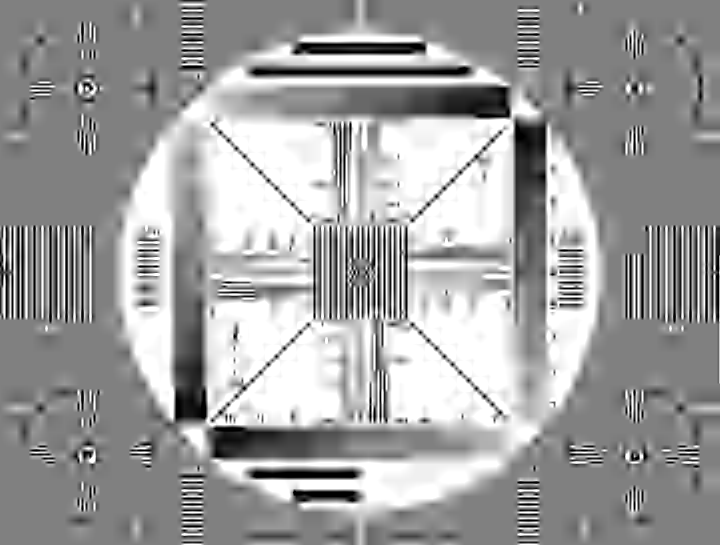

Size: 545x720
PSNR: 16.8 dB


In [13]:
# Decompressing using only a single layer

mono_decompressed_r0_l1 = decompress(mono_compressed, layers=1)
img_r0_l1 = Image.fromarray(mono_decompressed_r0_l1)
display(img_r0_l1)
ncol, nrow = img_r0_l1.size
psnr_l1 = psnr(mono_pixels,mono_decompressed_r0_l1,8)
print(f'Size: {nrow}x{ncol}')
print(f'PSNR: {psnr_l1:.1f} dB')

### (U) Resolution = 0 / Layers = 3

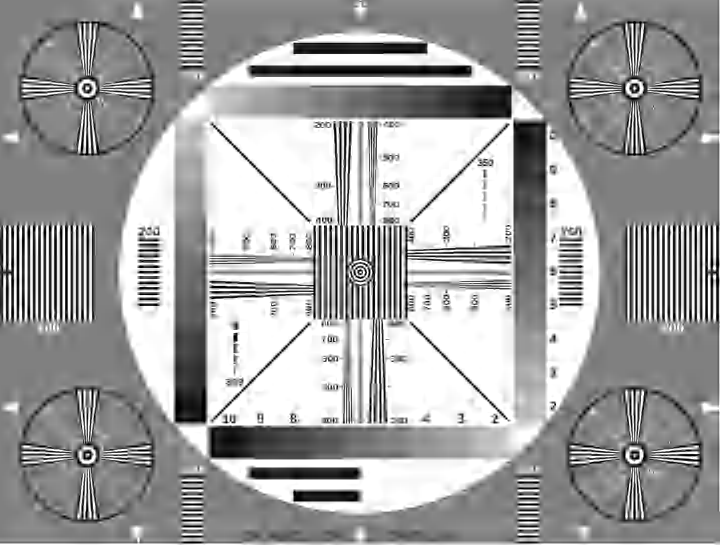

Size: 545x720
PSNR: 21.6 dB


In [14]:
# Decompress with resolution = 0, layers = 3, and render the result as an image
mono_decompressed_r0_l3 = decompress(mono_compressed, layers=3)
img_r0_l3 = Image.fromarray(mono_decompressed_r0_l3)
display(img_r0_l3)
ncol, nrow = img_r0_l3.size
psnr_l3 = psnr(mono_pixels,mono_decompressed_r0_l3,8)
print(f'Size: {nrow}x{ncol}')
print(f'PSNR: {psnr_l3:.1f} dB')

### (U) Resolution = 0 / Layers = 5

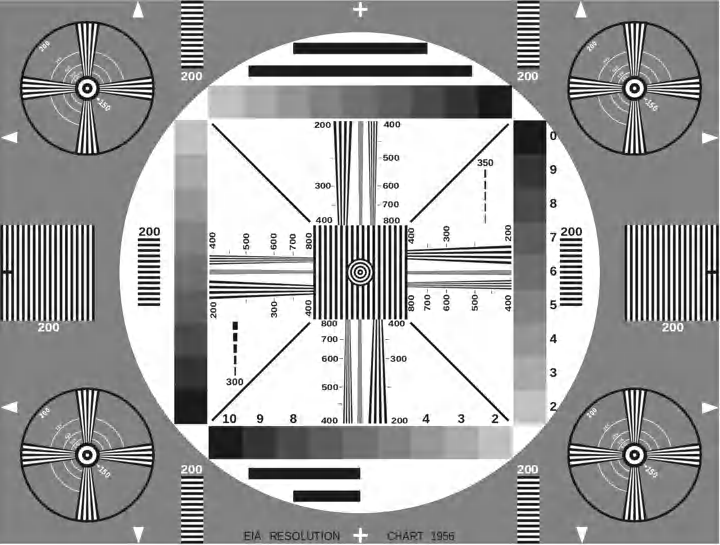

Size: 545x720
PSNR: 32.6 dB


In [15]:
# Decompress with resolution = 0, layers = 5, and render the result as an image
mono_decompressed_r0_l5 = decompress(mono_compressed, layers=5)
img_r0_l5 = Image.fromarray(mono_decompressed_r0_l5)
display(img_r0_l5)
ncol, nrow = img_r0_l5.size
psnr_l5 = psnr(mono_pixels,mono_decompressed_r0_l5,8)
print(f'Size: {nrow}x{ncol}')
print(f'PSNR: {psnr_l5:.1f} dB')

### (U) Resolution = 0 / Layers = 15

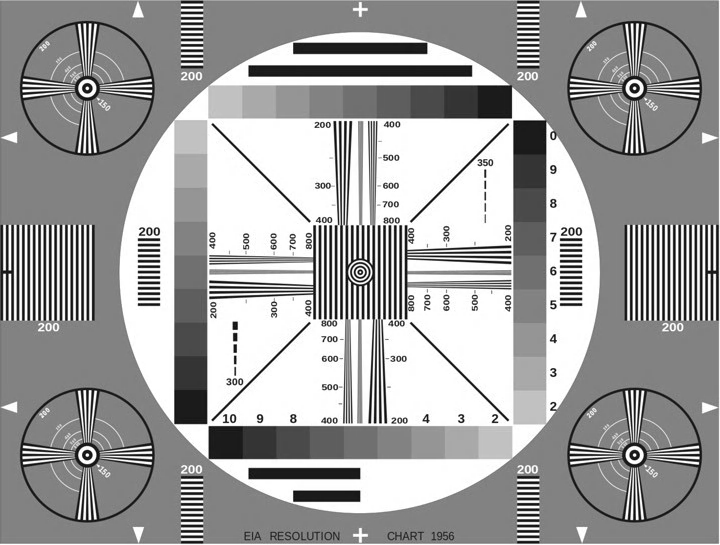

Size: 545x720
PSNR: 48.0 dB


In [16]:
# Decompress with resolution = 0, layers = 15, and render the result as an image
mono_decompressed_r0_l15 = decompress(mono_compressed, layers=15)
img_r0_l15 = Image.fromarray(mono_decompressed_r0_l15)
display(img_r0_l15)
ncol, nrow = img_r0_l15.size
psnr_l15 = psnr(mono_pixels,mono_decompressed_r0_l15,8)
print(f'Size: {nrow}x{ncol}')
print(f'PSNR: {psnr_l15:.1f} dB')

## <a name="sectionVLcomp"><font style=color:#4682b4;> (U) Visually Lossless (VL) Compression </font></a>

(U) Imagery which has been VL-compressed is converted into a J2K codestream such that when said codestream is decompressed, the result is an image wich is *essentially identical* to the original: the visual difference between the two images is indistinguishable to the human eye. 

(U) Just as with NL compression, images to undergo VL compression can still be segmented into tiles.

### (U) Three Components / Single Tile / NPJE Profile

(U) In this example, the same RGB image used above is compressed as a single tile using the visually lossless wavelet and the NPJE profile.

(U) We check that VL compression satisfies our requirements by computing PSNR for each component and asserting that each quantity be greater than 30 dB.

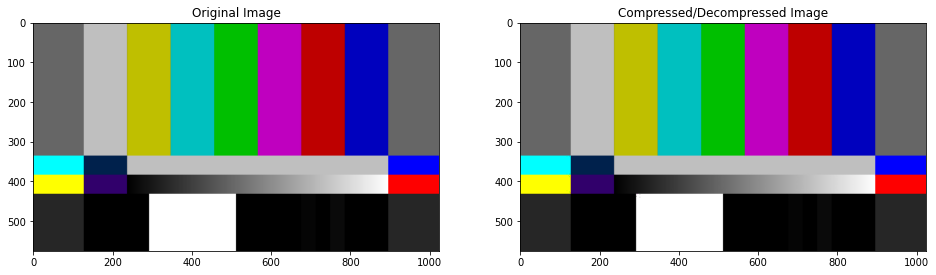

PSNR for red component: 71.2 dB
PSNR for green component: 71.2 dB
PSNR for blue component: 71.1 dB

__J2KLRA data___:
  nlevels: 5
  nlayers: 19
  bitrates: [0.03125, 0.0625, 0.125, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 2.0, 2.3, 2.8, 3.8]


In [17]:
rgb_compressed_vl,j2klra   = compress([rgb_pixels], num_rows=1, bpp=9, sgnd=False, 
                                compression_type="VL", profile="NPJE")

rgb_decompressed_vl = decompress(rgb_compressed_vl).astype('uint8')

# Visually compare the decompressed image to the original
rgb_final_img_vl = Image.fromarray(np.transpose(rgb_decompressed_vl, axes=(1, 2, 0)))

fig = plt.figure(figsize=(16,8))
fig.add_subplot(1,2,1)
plt.imshow(rgb_image)
plt.title('Original Image')
fig.add_subplot(1,2,2)
plt.imshow(rgb_final_img_vl)
plt.title('Compressed/Decompressed Image')
plt.show()

# Compute PSNR for each component
for i,comp in enumerate(('red','green','blue')):
    psnr_comp   = psnr(rgb_pixels[i], rgb_decompressed_vl[i], bits=8)
    print(f'PSNR for {comp} component: {psnr_comp:.1f} dB')

# Display the J2KLRA support data
print('\n__J2KLRA data___:')
for k,v in j2klra.items():
    print(f'  {k}: {v}')

## <a name="sectionVLdecomp"><font style=color:#4682b4;> (U) Decompression of VL-Compressed Codestream </font></a>

(U) Just as with NL compression, we can decompress a VL-compressed codestream using different values for ```resolution``` and ```layers```. This has an effect on the value of PSNR.

### (U) Resolution = 0 / Layers = 3

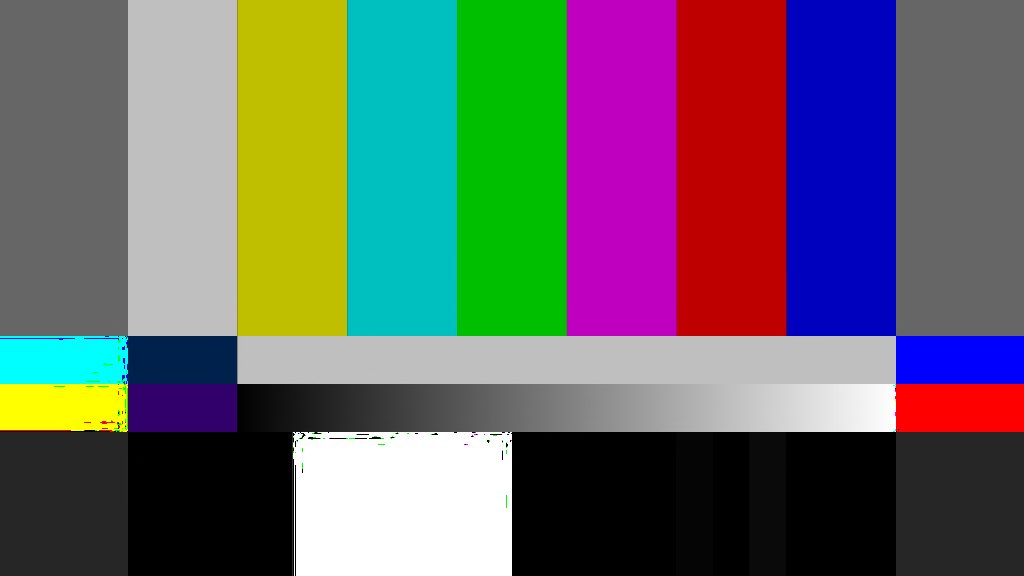

PSNR for red component: 62.5 dB
PSNR for green component: 63.2 dB
PSNR for blue component: 62.1 dB


In [18]:
# Decompress with resolution = 0, layers = 3, and render the result as an image
rgb_decompressed_vl_r0_l3 = decompress(rgb_compressed_vl, layers=3).astype('uint8')
rgb_vl_r0_l3 = Image.fromarray(np.transpose(rgb_decompressed_vl_r0_l3, axes=(1, 2, 0)))
display(rgb_vl_r0_l3)

# Compute PSNR for each component
for i,comp in enumerate(('red','green','blue')):
    psnr_comp   = psnr(rgb_pixels[i], rgb_decompressed_vl_r0_l3[i], bits=8)
    print(f'PSNR for {comp} component: {psnr_comp:.1f} dB')

## <a name="sectionSpark"><font style=color:#4682b4;> (U) Compression Using Spark</font></a>

(U) The J2K Library provides the capability to use Spark to parallelize the compression of the image tiles.  There is no difference in the compression capabilities provided by the non-Spark interface.  The only difference is how the uncompressed imagery data is provided to the compression function and how the compressed codestream is returned.

(U) Where the non-Spark interface uses the function ```cpaj2k.j2klib.j2k_compress.compress()```, the Spark interface uses the class ```cpaj2k.j2klib.spark.J2kCompressRDD```.

(U) Where the non-Spark interface passes a list of numpy arrays defining the tiles, the Spark interface uses an RDD (Resilient Distributed Dataset) to define the tiles.  Each element in the RDD is, however, still a numpy array following the same rules for size and ordering as for the non-Spark interface.

(U) Where the non-Spark interface returns a JPEG2000 compressed codestream for the entire image, the Spark interface returns an RDD of compressed codestreams where each codestream is for a single tile in the image.  The order of tiles in the RDD follows the same raster order used on input.  The first and last codestreams in the returned RDD are a bit special.  The first codestream has the J2K main header prepended to it.  The final codestream has the EOC marker appended to it.

(U) There are three convenience functions in cpaj2k.j2klib.spark for working with the returned RDD:
- s3_upload_j2k_rdd: handles the multipart upload of the RDD to an S3 file
- prepare_j2k_for_s3: converts the tile based RDD into a new RDD suitable for multipart upload to S3
- j2k_to_codestream: collects the RDD tile codestreams into a single codetream (bytes) for the image


### (U) Multi Tile

In this example, a monochromatic image is created that is large enough to result in a multipart S3 upload (i.e. each tile is larger thatn 5MB when compressed).  This is accomplished by compositing multiple copies of a larger verison of the same monochormatic image used above.

In [19]:
mono_image_large = Image.open(f"{images_path}/tv-test-pattern-mono-large.jpg")
mono_pixels_large = np.array(mono_image_large)
mono_pixels_xl = np.concatenate([mono_pixels_large for _ in range(4)],axis=0)
mono_pixels_xl = np.concatenate([mono_pixels_xl for _ in range(4)],axis=1)
(mono_pixels_large.shape,mono_pixels_xl.shape)

((2180, 2880), (8720, 11520))

In [20]:
# Create image tiles
height_mono_xl, width_mono_xl = mono_pixels_xl.shape
tile_width = 1024
tile_height = 1024
nrows_mono_xl = (height_mono_xl+tile_height-1)//tile_height
ncols_mono_xl = (width_mono_xl+tile_width-1)//tile_width
tiles_mono_xl = [ mono_pixels_xl[r*tile_height:(r+1)*tile_height, c*tile_width:(c+1)*tile_width] 
         for r in range(nrows_mono_xl) 
         for c in range(ncols_mono_xl)]

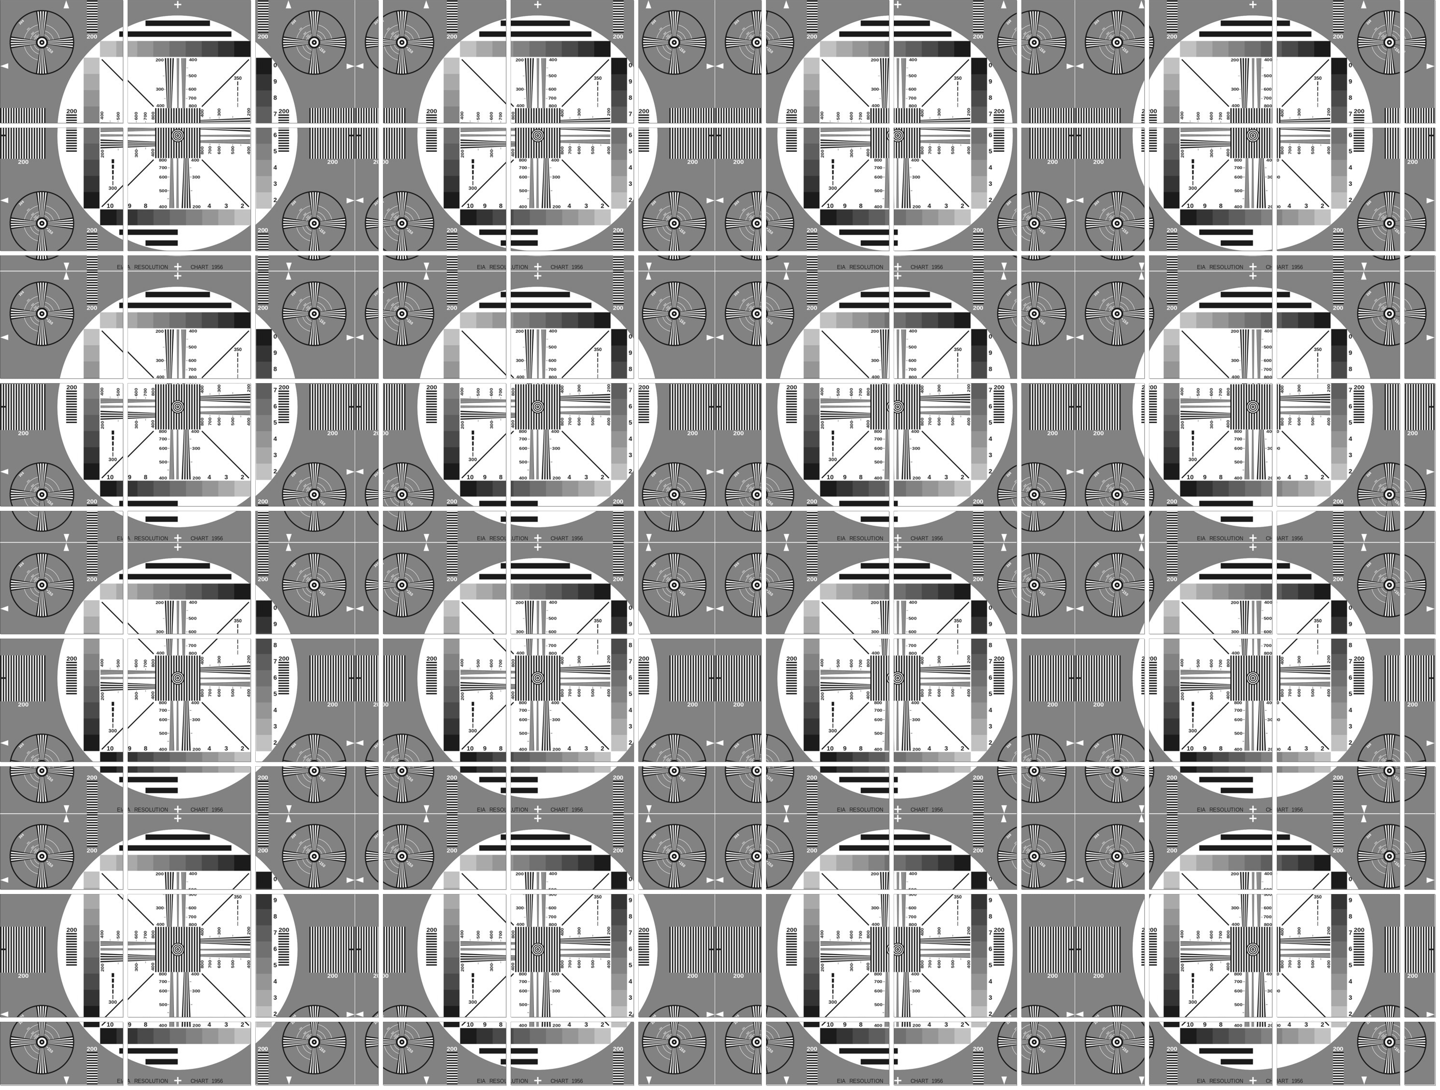

In [21]:
# Display tiles in raster order to visualize how, when combined, they span the whole image
tile_gap = 40
tiles_img = Image.new('RGB', (width_mono_xl + tile_gap*ncols_mono_xl,
                              height_mono_xl + tile_gap*nrows_mono_xl), 'white')
tiles_drw = ImageDraw.Draw(tiles_img)

def draw_tile(tile, box):
    tile_img = Image.fromarray(tile)
    tiles_drw.rectangle([x+5 for x in box], fill='#c0c0c0')
    tiles_img.paste(tile_img, (box[0], box[1]))
    tiles_drw.rectangle(box, outline='black')
    
for i,tile in enumerate(tiles_mono_xl):
    row = i // ncols_mono_xl
    col = i % ncols_mono_xl
    xo = (tile_width+tile_gap)*col
    yo = (tile_height+tile_gap)*row
    draw_tile(tile, (xo,yo,xo+tile.shape[1],yo+tile.shape[0]))
    
tiles_img = tiles_img.resize((1440,1090))
display(tiles_img)

In [22]:
# create RDD of tiles
sc = SparkSession.builder.appName("j2klib-tutorial").getOrCreate().sparkContext
mono_xl_rdd = sc.parallelize(tiles_mono_xl)

In [23]:
# Perform the compression
compress_rdd = J2kCompressRDD(compression_type='NL', profile='NPJE')

mono_xl_j2k_rdd,j2klra = compress_rdd(mono_xl_rdd, nrows_mono_xl, bpp=8, sgnd=False)

#We're going to do a couple things with the result, so let's cache it
mono_xl_j2k_rdd.cache()

# Display the J2KLRA support data
print('\n__J2KLRA data___:')
for k,v in j2klra.items():
    print(f'  {k}: {v}')


__J2KLRA data___:
  nlevels: 5
  nlayers: 20
  bitrates: [0.03125, 0.0625, 0.125, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 2.0, 2.3, 2.8, 3.8, 8]


### (U) Prepare decompressed image for S3 multipart upload (demos prepare_j2k_for_s3)
*Note that this step is not needed for s3_upload_j2k_rdd*

In [24]:
# Convert RDD from tile indexed elements to S3 mulipart upload indexed elements
mono_xl_s3_parts_rdd = prepare_j2k_for_s3(mono_xl_j2k_rdd).cache()

size_rdd_tiles = mono_xl_j2k_rdd.map(lambda x:len(x)).collect()
n_rdd_tiles = len(size_rdd_tiles)
bytes_rdd_tiles = np.sum(size_rdd_tiles)
size_rdd_parts = mono_xl_s3_parts_rdd.map(lambda x:len(x[1])).collect()
n_rdd_parts = len(size_rdd_parts)
bytes_rdd_parts = np.sum(size_rdd_parts)
print(f'Reduced {n_rdd_tiles} RDD tiles to {n_rdd_parts} RDD S3 parts')
print(f'\nSize RDD Tile Sizes: {size_rdd_tiles}')
print(f'\nSize RDD Part Sizes: {size_rdd_parts}')
if all(np.array(size_rdd_parts[:-1])>5*1024*1024):
    print('  All parts satisfy 5MB requirement for S3 multipart upload')
else:
    print('  At least one part fails to satisfy 5MB requirement for S3 multipart upload')
    
print(f'\nTotal Size RDD Tiles: {bytes_rdd_tiles}')
print(f'Total Size RDD Parts: {bytes_rdd_parts}')

Reduced 108 RDD tiles to 3 RDD S3 parts

Size RDD Tile Sizes: [135024, 115481, 143209, 130336, 126862, 152957, 120303, 132198, 150833, 118858, 140240, 29583, 149528, 142056, 149441, 149864, 143169, 161204, 143149, 143347, 157595, 148831, 145266, 34798, 127086, 107948, 133526, 126886, 120357, 141483, 116938, 123860, 142478, 114537, 132559, 25244, 152085, 157233, 151440, 151953, 155864, 163121, 150179, 154524, 157126, 158966, 151089, 36785, 142085, 99769, 147953, 139640, 113483, 159578, 121178, 122036, 160637, 113627, 139888, 28503, 124365, 169973, 125032, 130791, 164788, 129270, 141758, 154615, 123322, 159387, 137830, 30398, 168166, 85900, 174201, 159207, 103275, 193119, 128471, 120049, 194222, 111322, 151273, 35236, 103515, 174725, 104564, 113805, 168344, 102585, 133460, 153840, 95955, 157308, 126951, 25147, 90979, 55637, 91036, 90669, 60183, 101058, 76019, 66859, 102266, 68249, 82459, 18258]

Size RDD Part Sizes: [5345609, 5378306, 2661702]
  All parts satisfy 5MB requirement for S3 m

### (U) Upload decompressed image to S3 (demos s3_upload_j2k_rdd)

In [25]:
#   Note that this is the tile based RDD, NOT the part based RDD
try:
    s3 = boto3.client('s3')
    response = s3.list_buckets()
    result= s3_upload_j2k_rdd(mono_xl_j2k_rdd, s3_url='s3://cpaj2k/mono_xl.j2k')
    print(result)
except Exception as e:
    print(f"Cannot demonstrate S3 upload: {e}")

{'ResponseMetadata': {'RequestId': 'W659H7Z9RBVH0JTV', 'HostId': 'h+s49oS0c55Rm+4tJBg9o/2SBGZKdqGk2vR0p1zDPNQcNjpSOh4Lv5OMGhzZ8SaH947XoKuXBbQ=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'h+s49oS0c55Rm+4tJBg9o/2SBGZKdqGk2vR0p1zDPNQcNjpSOh4Lv5OMGhzZ8SaH947XoKuXBbQ=', 'x-amz-request-id': 'W659H7Z9RBVH0JTV', 'date': 'Thu, 22 Jul 2021 22:15:17 GMT', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3', 'cache-control': 'proxy-revalidate', 'proxy-connection': 'Keep-Alive', 'connection': 'Keep-Alive'}, 'RetryAttempts': 0}, 'Location': 'https://cpaj2k.s3.amazonaws.com/mono_xl.j2k', 'Bucket': 'cpaj2k', 'Key': 'mono_xl.j2k', 'ETag': '"87b3f14c2077cd6c8fa66ef8f554f38d-3"'}


### (U) Visually examine the decompressed image (demos j2k_rdd_codestream)

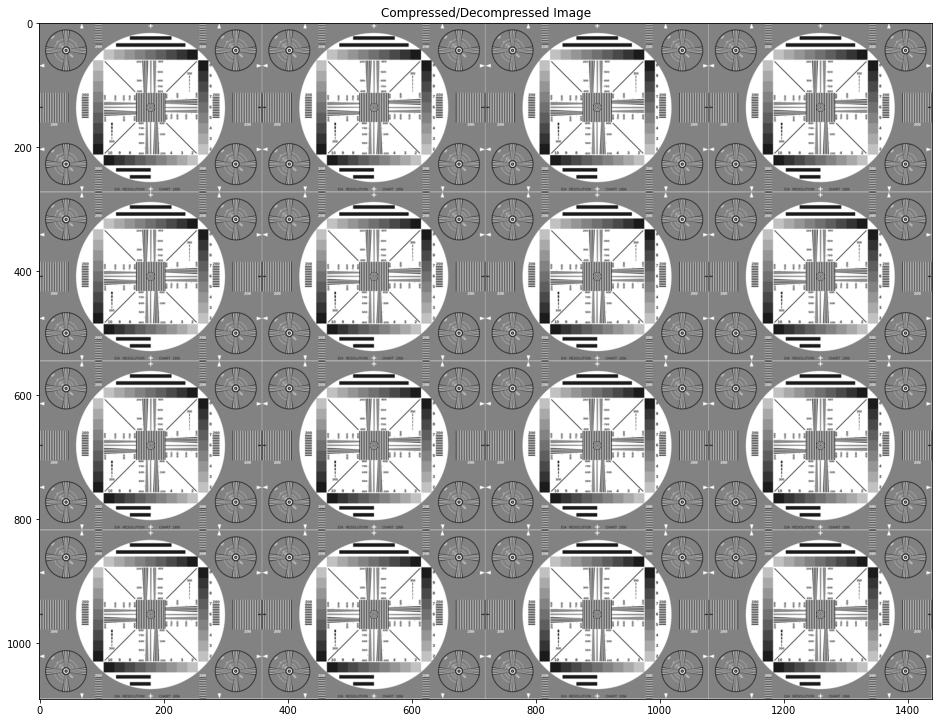

In [26]:
# Collect the image into a single codestream so that we can visually inspect and compute difference from original

mono_xl_j2k = j2k_rdd_codestream(mono_xl_j2k_rdd)
mono_xl_decompressed = decompress(mono_xl_j2k)

# Visually compare the decompressed image to the original
mono_xl_final_img = Image.fromarray(mono_xl_decompressed).resize((1440,1090))
fig = plt.figure(figsize=(16,16))
fig.add_subplot(1,1,1)
plt.imshow(mono_xl_final_img,cmap='gray')
plt.title('Compressed/Decompressed Image')
plt.show()